Este Codigo es Para Unir todos los Resultados en un solo CSV


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json 
import bibtexparser #pip install bibtexparser
import re

Estas funciones son para cargar los datos de los archivos

In [8]:
def cargarArchivotxt():
    files = []
    with open('./src/input_files.txt', 'r') as file:
        for line in file:
            # Dividir cada línea por la coma y agregar a la lista
            files.append(line.strip().split(','))
    return files

def cargarJson():
    archivoJson = {}
    with open('./src/columnas.json', 'r') as file:
        archivoJson = json.load(file)
    return archivoJson

Funcion Para obtener los Abstracts de Taylor&Francis

In [14]:
import requests
import bibtexparser

# Lista de rutas de archivos .bib descargados
rutas_archivos = ["../Bases/taylor_y_francis/taylor_francis (1).bib",
                  "../Bases/taylor_y_francis/taylor_francis (2).bib",
                    "../Bases/taylor_y_francis/taylor_francis (3).bib",
                    "../Bases/taylor_y_francis/taylor_francis (4).bib",
                    "../Bases/taylor_y_francis/taylor_francis (5).bib",
                    "../Bases/taylor_y_francis/taylor_francis (6).bib",
                    "../Bases/taylor_y_francis/taylor_francis (7).bib"] 


def obtener_abstract_semantic_scholar(doi):
    url = f"https://api.semanticscholar.org/v1/paper/{doi}"
    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            return data.get('abstract', 'No abstract available')
        else:
            print(f"Error: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error al obtener el abstract: {e}")
        return None


# Base de datos combinada para todas las entradas
todas_las_entradas = []

# Procesar cada archivo .bib y agregar abstracts
for ruta in rutas_archivos:
    try:
        with open(ruta, encoding="utf-8") as bibtex_file:  # Especificar la codificación UTF-8
            bib_database = bibtexparser.load(bibtex_file)
            i = 0
            # Procesar cada entrada en el archivo actual
            for entry in bib_database.entries:
                i += 1
                if "doi" in entry:
                    abstract = obtener_abstract_semantic_scholar(entry["doi"])
                    if abstract: 
                        entry["abstract"] = abstract
                        print("Efectivamente funciona la Api XD articulo numero: " + str(i))
                # Agregar la entrada a la lista de todas las entradas
                todas_las_entradas.append(entry)
    except UnicodeDecodeError:
        print(f"Error de codificación al leer el archivo {ruta}. Intentando con codificación diferente.")
        with open(ruta, encoding="latin1") as bibtex_file:  # Intentar con codificación alternativa (latin1)
            bib_database = bibtexparser.load(bibtex_file)
            for entry in bib_database.entries:
                if "doi" in entry:
                    abstract = obtener_abstract_semantic_scholar(entry["doi"])
                    if abstract:
                        entry["abstract"] = abstract
                todas_las_entradas.append(entry)

# Crear la base de datos combinada
bib_database_combinada = bibtexparser.bibdatabase.BibDatabase()
bib_database_combinada.entries = todas_las_entradas

# Guardar el archivo .bib combinado con abstracts
with open("../Bases/taylor_y_francis/taylor_francis_Final.bib", "w") as bibtex_file:
    bibtexparser.dump(bib_database_combinada, bibtex_file)

print("Proceso completado. Archivo combinado guardado como .bib")


Error: 404
Error: 404
Error: 404
Error: 404
Error: 404
Error: 404
Error: 404
Error: 404
Error: 404
Error: 404
Error: 404
Error: 404
Error: 404
Error: 404
Error: 404
Error: 404
Error: 404
Error: 404


KeyboardInterrupt: 

Esta Funcion es Para unir todo en un solo CSV, y Limpiar los datos, eliminar repetidos, filtrar por la fecha > 2004, y dejar los valores nulos como "sin valor".


In [3]:
# Función para limpiar y transformar los datos
def clean_and_transform_csv(file_path, source):
    # Leer el archivo CSV original
    df = pd.read_csv(file_path)
    
    # Mapeo de columnas de los CSV originales a las columnas del nuevo formato
    column_mapping = cargarJson()

    # Crear un nuevo DataFrame con las columnas deseadas
    new_df = pd.DataFrame()

    for new_col, old_col in column_mapping.items():
        if isinstance(old_col, list):
            # Si es una lista de posibles nombres de columnas, usar la primera que exista
            for col in old_col:
                if col in df.columns:
                    new_df[new_col] = df[col]
                    break
        else:
            # Si es solo un nombre de columna
            if old_col in df.columns:
                new_df[new_col] = df[old_col]

    # Rellenar la columna de "Database" con el nombre de la fuente de datos
    new_df['Database'] = source

    return new_df

# Función para limpiar y transformar datos de .bib
def clean_and_transform_bib(file_path, source):
    with open(file_path, encoding='utf-8') as bibfile:
        bib_database = bibtexparser.load(bibfile)

    records = []
    for entry in bib_database.entries:
        # Eliminar caracteres no numéricos del final del año usando expresiones regulares
        year_value = entry.get('year', 'Sin Valor')
        year_value = re.sub(r'\D+$', '', year_value)  # Sustituye caracteres no numéricos al final

        record = {
            'Authors': entry.get('author', 'Sin Valor'),
            'Title': entry.get('title', 'Sin Valor'),
            'Year': year_value,
            'Volume': entry.get('volume', 'Sin Valor'),
            'Issue': entry.get('number', 'Sin Valor'),
            'Start Page': entry.get('pages', 'Sin Valor').split('-')[0] if 'pages' in entry else 'Sin Valor',
            'End Page': entry.get('pages', 'Sin Valor').split('-')[1] if 'pages' in entry and '-' in entry['pages'] else 'Sin Valor',
            'Abstract': entry.get('abstract', 'Sin Valor'),
            'DOI': entry.get('doi', 'Sin Valor'),
            'Author Keywords': entry.get('keywords', 'Sin Valor'),
            'Publisher': entry.get('publisher','Sin Valor'),
            'ISSN': entry.get('issn', 'Sin Valor'),
            'ISBN': entry.get('isbn', 'Sin Valor'),
            'Publication Title': entry.get('journal', 'Sin Valor'),
            'Document Type': entry.get('entrytype', 'Sin Valor'),
            'Article Citation Count': entry.get('citation', 'Sin Valor'),
            'Link': entry.get('url', entry.get('URL', 'Sin Valor')),
            'Database': source
        }
        records.append(record)

    return pd.DataFrame(records)

In [4]:
# Archivos de entrada
files = cargarArchivotxt()
# Lista para almacenar los DataFrames procesados
dataframes = []

# Limpiar y transformar los archivos
for file in files:
    if file[0].endswith('.csv'):
        df = clean_and_transform_csv(file[0], file[1])
    elif file[0].endswith('.bib'):
        df = clean_and_transform_bib(file[0], file[1])
    dataframes.append(df)


# Concatenar los dos DataFrames
combined_df = pd.concat(dataframes, ignore_index=True)

#Eliminar duplicados basados en el DOI (o cualquier otra columna única)
combined_df.drop_duplicates(subset='DOI', keep='first', inplace=True)

# Convertir la columna 'Year' a entero
combined_df['Year'] = combined_df['Year'].astype(int)

# Filtrar artículos con año de publicación menor que 2004
combined_df = combined_df[(combined_df['Year'] >= 2004) & (combined_df['Year'] <= 2024)]

# Reemplazar valores nulos con "Sin Valor"
combined_df.fillna("Sin Valor", inplace=True)

# Guardar el DataFrame combinado y filtrado en un nuevo archivo CSV
output_file = '../CSV final/baseDatosFinal.csv'
combined_df.to_csv(output_file, index=False)

print(f"Archivo CSV combinado y filtrado guardado en: {output_file}")


Archivo CSV combinado y filtrado guardado en: ../CSV final/baseDatosFinal.csv


<Axes: xlabel='Database'>

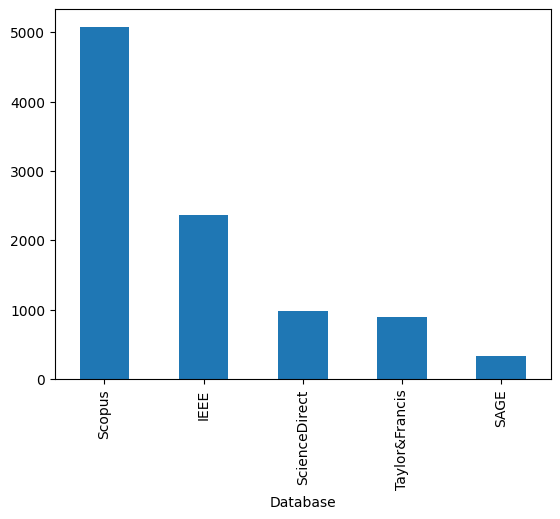

In [6]:
tabla = pd.read_csv('../CSV final/baseDatosFinal.csv')
fechas = tabla['Database'].value_counts()
fechas.plot.bar()